In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
sys.path.insert(0, '../../esinet')

from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both', verbose=0)

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')
source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]
leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    4.2s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s finished


No projector specified for this dataset. Please consider the method self.add_proj.


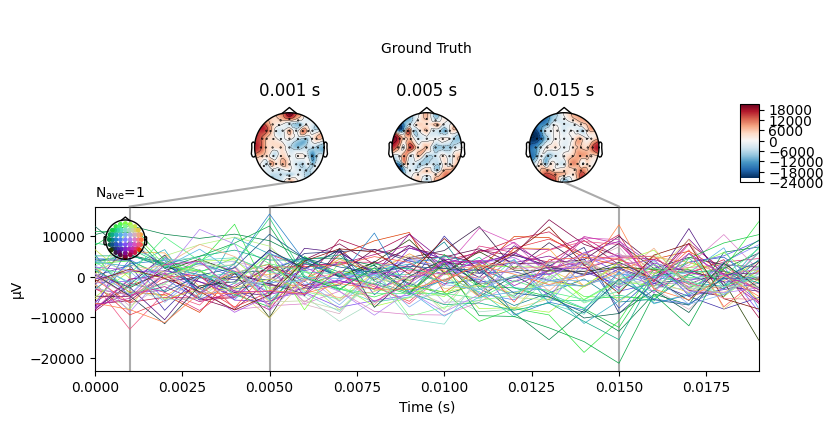

In [3]:
from invert.solvers.esinet import generator

sim_params = dict(
    use_cov=False, 
    return_mask=False, 
    batch_repetitions=1,
    batch_size=1,
    n_sources=6, 
    n_orders=(0, 1), 
    snr_range=(3, 4), 
    n_timecourses=200,
    scale_data=False)
    
gen = generator(fwd, **sim_params)

x, y = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)
                        
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

# Beamformer

In [5]:

def correlated_beamformer(eeg_data, leadfield_matrix, source_covariance):
    """
    Solves the EEG inverse problem using a beamformer algorithm that can handle correlated sources.
    
    Parameters:
    - eeg_data: A 2D array of shape (num_sensors, num_samples) containing the EEG data measured by the sensors.
    - leadfield_matrix: A 2D array of shape (num_sensors, num_sources) containing the leadfield forward matrix.
    - source_covariance: A 2D array of shape (num_sources, num_sources) containing the covariance of the sources.
    
    Returns:
    - source_estimate: A 2D array of shape (num_sources, num_samples) containing the estimated sources.
    """
    # Compute the spatial filters using the leadfield matrix and the source covariance
    spatial_filters = compute_spatial_filters(leadfield_matrix, source_covariance)
    # spatial_filters = spatial_filters / np.linalg.norm(spatial_filters, axis=0)
    # Compute the source estimate using the spatial filters and the EEG data
    source_estimate = compute_source_estimate(eeg_data, spatial_filters)
    
    return source_estimate

def compute_spatial_filters(leadfield_matrix, source_covariance):
    """
    Computes the spatial filters using the leadfield matrix and the source covariance.
    
    Parameters:
    - leadfield_matrix: A 2D array of shape (num_sensors, num_sources) containing the leadfield forward matrix.
    - source_covariance: A 2D array of shape (num_sources, num_sources) containing the covariance of the sources.
    
    Returns:
    - spatial_filters: A 2D array of shape (num_sources, num_sensors) containing the spatial filters.
    """
    # Compute the spatial filters using the leadfield matrix and the source covariance
    spatial_filters = np.dot(np.linalg.inv(source_covariance), leadfield_matrix)
    
    return spatial_filters

def compute_source_estimate(eeg_data, spatial_filters):
    """
    Computes the source estimate using the EEG data and the spatial filters.
    
    Parameters:
    - eeg_data: A 2D array of shape (num_sensors, num_samples) containing the EEG data measured by the sensors.
    - spatial_filters: A 2D array of shape (num_sources, num_sensors) containing the spatial filters.
    
    Returns:
    - source_estimate: A 2D array of shape (num_sources, num_samples) containing the estimated sources.
    """
    # Compute the source estimate using the spatial filters and the EEG data
    source_estimate = np.dot(spatial_filters.T, eeg_data)
    
    return source_estimate


y = evoked.data
y -= y.mean(axis=0)
y /= np.linalg.norm(y)
C = y@y.T
C -= C.mean(axis=0)
C /= np.linalg.norm(C, axis=0)
n_chans, n_times = y.shape
n_dipoles = leadfield.shape[1]

leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)

x0 = np.linalg.pinv(leadfield) @ y
x0 /= np.linalg.norm(x0)

x = correlated_beamformer(y, leadfield, C)

stc_ = stc.copy()
stc_.data = x/abs(x).max()
stc_.plot(**pp)

Using control points [0.12121437 0.12640028 0.22858153]
Using control points [0.00272278 0.03100168 0.71883569]
Using control points [6.20782946e-04 7.06826118e-03 9.23808276e-01]
Using control points [0.44557028 0.46215734 0.7931788 ]
Using control points [0.44557028 0.46215734 0.7931788 ]


# Beamformer 2

In [ ]:
def correlated_beamformer(eeg_data, leadfield_matrix, source_covariance, lambda_):
    """
    Solves the EEG inverse problem using a beamformer algorithm that can handle correlated sources and promotes sparsity in the solutions.
    
    Parameters:
    - eeg_data: A 2D array of shape (num_sensors, num_samples) containing the EEG data measured by the sensors.
    - leadfield_matrix: A 2D array of shape (num_sensors, num_sources) containing the leadfield forward matrix.
    - source_covariance: A 2D array of shape (num_sources, num_sources) containing the covariance of the sources.
    - lambda_: The regularization parameter that controls the amount of sparsity in the solutions.

    Returns:
    - source_estimate: A 2D array of shape (num_sources, num_samples) containing the estimated sources.
    """
    # Compute the spatial filters using the leadfield matrix, source covariance, and regularization parameter
    spatial_filters = compute_spatial_filters(leadfield_matrix, source_covariance, lambda_)

    # Compute the source estimate using the spatial filters and the EEG data
    source_estimate = compute_source_estimate(eeg_data, spatial_filters)

    return source_estimate

def compute_spatial_filters(leadfield_matrix, source_covariance, lambda_):
    """
    Computes the spatial filters using the leadfield matrix, source covariance, and regularization parameter.
    Parameters:
    - leadfield_matrix: A 2D array of shape (num_sensors, num_sources) containing the leadfield forward matrix.
    - source_covariance: A 2D array of shape (num_sources, num_sources) containing the covariance of the sources.
    - lambda_: The regularization parameter that controls the amount of sparsity in the solutions.

    Returns:
    - spatial_filters: A 2D array of shape (num_sources, num_sensors) containing the spatial filters.
    """
    # Compute the regularized spatial filters using the leadfield matrix, source covariance, and regularization parameter
    spatial_filters = np.dot(np.linalg.inv(source_covariance + lambda_ * np.eye(source_covariance.shape[0])), leadfield_matrix).T

    return spatial_filters

def compute_source_estimate(eeg_data, spatial_filters):
    """
    Computes the source estimate using the EEG data and the spatial filters.
    Parameters:
    - eeg_data: A 2D array of shape (num_sensors, num_samples) containing the EEG data measured by the sensors.
    - spatial_filters: A 2D array of shape (num_sources, num_sensors) containing the spatial filters.

    Returns:
    - source_estimate: A 2D array of shape (num_sources, num_samples) containing the estimated sources.
    """
    # Compute the source estimate using the spatial filters and the EEG data
    source_estimate = np.dot(spatial_filters, eeg_data)

    return source_estimate



y = evoked.data
y -= y.mean(axis=0)
y /= np.linalg.norm(y)
C = y@y.T
C -= C.mean(axis=0)
C /= np.linalg.norm(C, axis=0)
n_chans, n_times = y.shape
n_dipoles = leadfield.shape[1]

leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)

x0 = np.linalg.pinv(leadfield) @ y
x0 /= np.linalg.norm(x0)
lambda_ = 1e2
x = correlated_beamformer(y, leadfield, C, lambda_)

stc_ = stc.copy()
stc_.data = x/abs(x).max()
stc_.plot(**pp)

# FISTA Beamformer

In [15]:
import numpy as np

def correlated_beamformer(eeg_data, leadfield_matrix, source_covariance, lambda_, threshold):
    """
    Solves the EEG inverse problem using a beamformer algorithm that can handle correlated sources and promotes sparsity in the solutions using thresholding.
    
    Parameters:
    - eeg_data: A 2D array of shape (num_sensors, num_samples) containing the EEG data measured by the sensors.
    - leadfield_matrix: A 2D array of shape (num_sensors, num_sources) containing the leadfield forward matrix.
    - source_covariance: A 2D array of shape (num_sources, num_sources) containing the covariance of the sources.
    - lambda_: The regularization parameter that controls the amount of sparsity in the solutions.
    - threshold: The threshold used to make the solutions more sparse.
    
    Returns:
    - source_estimate: A 2D array of shape (num_sources, num_samples) containing the estimated sources.
    """
    # Compute the spatial filters using the leadfield matrix, source covariance, and regularization parameter
    spatial_filters = compute_spatial_filters(leadfield_matrix, source_covariance, lambda_)
    
    # Threshold the spatial filters to make the solutions more sparse
    spatial_filters = threshold_spatial_filters(spatial_filters, threshold)
    
    # Compute the source estimate using the spatial filters and the EEG data
    source_estimate = compute_source_estimate(eeg_data, spatial_filters)
    
    return source_estimate

def compute_spatial_filters(leadfield_matrix, source_covariance, lambda_):
    """
    Computes the spatial filters using the leadfield matrix, source covariance, and regularization parameter.
    
    Parameters:
    - leadfield_matrix: A 2D array of shape (num_sensors, num_sources) containing the leadfield forward matrix.
    - source_covariance: A 2D array of shape (num_sources, num_sources) containing the covariance of the sources.
    - lambda_: The regularization parameter that controls the amount of sparsity in the solutions.
    Returns:
    - spatial_filters: A 2D array of shape (num_sources, num_sensors) containing the spatial filters.
    """
    # Compute the regularized spatial filters using the leadfield matrix, source covariance, and regularization parameter
    spatial_filters = np.dot(np.linalg.inv(source_covariance + lambda_ * np.eye(source_covariance.shape[0])), leadfield_matrix)

    return spatial_filters

def threshold_spatial_filters(spatial_filters, threshold):
    """
    Thresholds the spatial filters to make the solutions more sparse.
    Parameters:
    - spatial_filters: A 2D array of shape (num_sources, num_sensors) containing the spatial filters.
    - threshold: The threshold used to make the solutions more sparse.

    Returns:
    - spatial_filters: A 2D array of shape (num_sources, num_sensors) containing the thresholded spatial filters.
    """
    # Threshold the spatial filters by setting elements with absolute value less than the threshold to zero
    spatial_filters[np.abs(spatial_filters) < threshold] = 0

    return spatial_filters

def compute_source_estimate(eeg_data, spatial_filters):
    """
    Computes the source estimate using the EEG data and the spatial filters.

    Parameters:
    - eeg_data: A 2D array of shape (num_sensors, num_samples) containing the EEG data measured by the sensors.
    - spatial_filters: A 2D array of shape (num_sources, num_sensors) containing the spatial filters.

    Returns:
    - source_estimate: A 2D array of shape (num_sources, num_samples) containing the estimated sources.
    """
    # Compute the source estimate using the spatial filters and the EEG data
    source_estimate = np.dot(spatial_filters.T, eeg_data)

    return source_estimate



y = evoked.data
y -= y.mean(axis=0)
y /= np.linalg.norm(y)
C = y@y.T
C -= C.mean(axis=0)
C /= np.linalg.norm(C, axis=0)
n_chans, n_times = y.shape
n_dipoles = leadfield.shape[1]

leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)

x0 = np.linalg.pinv(leadfield) @ y
x0 /= np.linalg.norm(x0)
lambda_ = 1e3
threshold =0
x = correlated_beamformer(y, leadfield, C, lambda_, threshold)

stc_ = stc.copy()
stc_.data = x/abs(x).max()
stc_.plot(**pp)


Using control points [0.50722457 0.5346325  0.62398081]
Using control points [0.84352866 0.86190975 0.93936226]


# L1L2 FISTA

In [8]:
import numpy as np

def fista_eeg(A, y, l1_spatial, l2_temporal, max_iter=100, tol=1e-6):
    """
    Solves the EEG inverse problem using FISTA with L1 regularization on the spatial
    dimension and L2 regularization on the temporal dimension.
    
    Parameters:
    - A: array of shape (n_sensors, n_sources)
    - y: array of shape (n_sensors, n_timepoints)
    - l1_spatial: float, strength of L1 regularization on the spatial dimension
    - l2_temporal: float, strength of L2 regularization on the temporal dimension
    - max_iter: int, maximum number of iterations
    - tol: float, tolerance for convergence
    
    Returns:
    - x: array of shape (n_sources, n_timepoints), the solution to the EEG inverse problem
    """
    # Initialize x and z to be the same, and set t to 1
    x = z = np.linalg.pinv(A) @ y
    t = 1
    
    # Compute the Lipschitz constant
    L = np.linalg.norm(A, ord=2) ** 2
    
    for i in range(max_iter):
        # Compute the gradient of the smooth part of the objective
        grad = A.T @ (A @ x - y)
        
        # Compute the proximal operator of the L1 regularization
        x_new = np.sign(x - grad / L) * np.maximum(np.abs(x - grad / L) - l1_spatial / L, 0)
        
        # Compute the proximal operator of the L2 regularization
        x_new = x_new - np.mean(x_new, axis=0)
        x_new = x_new / np.linalg.norm(x_new, ord=2, axis=0) * np.maximum(np.linalg.norm(x_new, ord=2, axis=0) - l2_temporal / L, 0)
        x_new = x_new + np.mean(x_new, axis=0)
        
        # Update t and z
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        z_new = x_new + (t - 1) / t_new * (x_new - x)
        
        # Check for convergence
        if np.linalg.norm(x_new - x) < tol:
            break
            
        # Update x, t, and z
        x = x_new
        t = t_new
        z = z_new
    
    return x
    
y = evoked.data
y -= y.mean(axis=0)
y /= np.linalg.norm(y)
C = y@y.T
C -= C.mean(axis=0)
C /= np.linalg.norm(C, axis=0)
n_chans, n_times = y.shape
n_dipoles = leadfield.shape[1]

leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)

x0 = np.linalg.pinv(leadfield) @ y
x0 /= np.linalg.norm(x0)
l1_spatial = 1e-3
l2_temporal = 1e-3
x = fista_eeg(leadfield, y, l1_spatial, l2_temporal, max_iter=100, tol=1e-6)

stc_ = stc.copy()
stc_.data = x/abs(x).max()
stc_.plot(**pp)


Using control points [0.         0.         0.54799178]


# Bayesian inference

In [22]:
import numpy as np

def eeg_inverse_solution(eeg_data, leadfield_matrix, noise_covariance, prior_mean, prior_covariance):
  """
  Compute the EEG inverse solution using Bayesian inference.

  Parameters:
  - eeg_data: 1D array of shape (n_sensors,) representing the measured EEG data.
  - leadfield_matrix: 2D array of shape (n_sensors, n_sources) representing the leadfield matrix.
  - noise_covariance: 2D array of shape (n_sensors, n_sensors) representing the noise covariance matrix.
  - prior_mean: 1D array of shape (n_sources,) representing the prior mean for the sources.
  - prior_covariance: 2D array of shape (n_sources, n_sources) representing the prior covariance for the sources.

  Returns:
  - posterior_mean: 1D array of shape (n_sources,) representing the posterior mean for the sources.
  - posterior_covariance: 2D array of shape (n_sources, n_sources) representing the posterior covariance for the sources.
  """

  # Compute the posterior mean and covariance using Bayesian inference
  posterior_mean = np.linalg.inv(leadfield_matrix.T @ np.linalg.inv(noise_covariance) @ leadfield_matrix + np.linalg.inv(prior_covariance)) @ (leadfield_matrix.T @ np.linalg.inv(noise_covariance) @ eeg_data + np.linalg.inv(prior_covariance) @ prior_mean)
  posterior_covariance = np.linalg.inv(leadfield_matrix.T @ np.linalg.inv(noise_covariance) @ leadfield_matrix + np.linalg.inv(prior_covariance))

  return posterior_mean, posterior_covariance


def iterative_bayes(eeg_data, leadfield_matrix, max_iter=100):
  
  noise_covariance, prior_mean, prior_covariance = [np.identity(n_chans), np.ones(n_dipoles), np.identity(n_dipoles)]
  posterior_mean, posterior_covariance = eeg_inverse_solution(eeg_data, leadfield_matrix, noise_covariance, prior_mean, prior_covariance)
  for i in range(max_iter):
    print(i)
    posterior_mean, posterior_covariance = eeg_inverse_solution(eeg_data, leadfield_matrix, noise_covariance, posterior_mean, posterior_covariance)
  return posterior_mean, posterior_covariance



y = evoked.data
y -= y.mean(axis=0)
y /= np.linalg.norm(y)
C = y@y.T
C -= C.mean(axis=0)
C /= np.linalg.norm(C, axis=0)
n_chans, n_times = y.shape
n_dipoles = leadfield.shape[1]

leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)

x0 = np.linalg.pinv(leadfield) @ y
x0 /= np.linalg.norm(x0)
l1_spatial = 1e-3
l2_temporal = 1e-3
posterior_mean, posterior_covariance = iterative_bayes(y[:, 0], leadfield, max_iter=100)

stc_ = stc.copy()
# stc_.data = x/abs(x).max()
stc_.data *= 0
stc_.data[:, 0] = posterior_mean / np.diag(posterior_covariance)
stc_.plot(**pp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Using control points [1.3644244  1.41674047 2.93287074]


# FOCUSS

In [35]:
import numpy as np

def focuss(A, b, k, maxiter=100, tol=1e-6):
    """
    Solve the underdetermined linear system Ax = b using the FOCUSS algorithm.
    
    Parameters
    ----------
    A : array-like, shape (m, n)
        The matrix of the linear system.
    b : array-like, shape (m,)
        The right-hand side of the linear system.
    k : int
        The target sparsity level for the solution x.
    maxiter : int, optional
        The maximum number of iterations to run the FOCUSS algorithm.
    tol : float, optional
        The tolerance for convergence of the FOCUSS algorithm.
    
    Returns
    -------
    x : array, shape (n,)
        The solution of the linear system, with sparsity k.
    """
    # Initialize the solution x with all zeros
    x = np.zeros(A.shape[1])
    # x = np.linalg.pinv(A) @ b
    
    
    # Initialize the residual r with b
    r = b
    
    # Initialize the active set S with an empty list
    S = []
    
    # Initialize the iteration counter
    it = 0
    
    # Run the FOCUSS algorithm until convergence or maximum iterations reached
    while it < maxiter and np.linalg.norm(r) > tol:
        # Increment the iteration counter
        it += 1
        
        # Find the index of the largest absolute value in the residual
        i = np.argmax(np.abs(r))
        print("select ", i)
        
        # Add the index to the active set S
        S.append(i)
        
        # Compute the solution x using the indices in the active set S
        x[S] = np.linalg.lstsq(A[:, S], b, rcond=None)[0]
        
        # Compute the residual r
        r = b - np.dot(A, x)
        
        # If the active set S is larger than the target sparsity, remove the smallest element
        if len(S) > k:
            # Find the index of the smallest absolute value in the solution x
            j = np.argmin(np.abs(x[S]))
            
            # Remove the index from the active set S
            S.pop(j)
        
    
    return x


y = evoked.data
y -= y.mean(axis=0)
y /= np.linalg.norm(y)
C = y@y.T
C -= C.mean(axis=0)
C /= np.linalg.norm(C, axis=0)
n_chans, n_times = y.shape
n_dipoles = leadfield.shape[1]

leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)

x0 = np.linalg.pinv(leadfield) @ y
x0 /= np.linalg.norm(x0)

x = focuss(leadfield, y[:, 0], 10, maxiter=1000, tol=1e-6)

stc_ = stc.copy()
stc_.data[:, 0] = x/abs(x).max()
stc_.plot(**pp)

select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2
select  2


# ST FOCUSS

In [ ]:
import numpy as np

def focuss(A, b, k, T, maxiter=100, tol=1e-6):
    """
    Solve the underdetermined linear system Ax = b using the FOCUSS algorithm for spatio-temporal EEG data.
    
    Parameters
    ----------
    A : array-like, shape (m, n)
        The matrix of the linear system.
    b : array-like, shape (m, T)
        The right-hand side of the linear system, with T time points.
    k : int
        The target sparsity level for the solution x.
    T : int
        The number of time points in the EEG data.
    maxiter : int, optional
        The maximum number of iterations to run the FOCUSS algorithm.
    tol : float, optional
        The tolerance for convergence of the FOCUSS algorithm.
    
    Returns
    -------
    x : array, shape (n, T)
        The solution of the linear system, with sparsity k, at each time point.
    """
    # Initialize the solution x with all zeros
    x = np.zeros((A.shape[1], T))
    
    # Loop over each time point
    for t in range(T):
        # Initialize the residual r with b at the current time point
        r = b[:, t]
        
        # Initialize the active set S with an empty list
        S = []
        
        # Initialize the iteration counter
        it = 0
        
        # Run the FOCUSS algorithm until convergence or maximum iterations reached
        while it < maxiter and np.linalg.norm(r) > tol:
            # Increment the iteration counter
            it += 1
            
            # Find the index of the largest absolute value in the residual
            i = np.argmax(np.abs(r))
            
            # Add the index to the active set S
            S.append(i)
            
            # Compute the solution x using the indices in the active set S
            x[S, t] = np.linalg.lstsq(A[:, S], r, rcond=None)[0]
            
            # Compute the residual r
            r = b[:, t] - np.dot(A, x[:, t])
            
            # If the active set S is larger than the target sparsity, remove the smallest element
            if len(S) > k:
                # Find the index of the smallest absolute value in the solution x
                j = np.argmin(np.abs(x[S, t]))
                
                # Remove the index from the active set S
                S.pop(j)
    
    return x


# Bayesian Beamformer

In [8]:
import numpy as np

def bayesian_beamformer(eeg_data, leadfield_matrix, noise_covariance, regularization_parameter):
  """
  Solves the EEG inverse problem using a Bayesian beamformer.
  
  Parameters:
  - eeg_data: An (n_channels, n_timepoints) array of EEG data.
  - leadfield_matrix: An (n_sources, n_channels) array representing the forward model.
  - noise_covariance: An (n_channels, n_channels) array representing the noise covariance matrix.
  - regularization_parameter: A scalar representing the regularization parameter.
  
  Returns:
  - source_activity: An (n_sources, n_timepoints) array representing the estimated source activity.
  """
  
  # Compute the inverse of the noise covariance matrix
  noise_covariance_inv = np.linalg.inv(noise_covariance)
  
  # Compute the covariance of the leadfield matrix
  leadfield_covariance = np.dot(leadfield_matrix.T, np.dot(noise_covariance_inv, leadfield_matrix))
  
  # Add the regularization term to the leadfield covariance
  leadfield_covariance += regularization_parameter * np.eye(leadfield_matrix.shape[1])
  
  # Compute the inverse of the leadfield covariance
  leadfield_covariance_inv = np.linalg.inv(leadfield_covariance)
  
  # Compute the source activity estimate
  source_activity = np.dot(leadfield_covariance_inv, np.dot(leadfield_matrix.T, np.dot(noise_covariance_inv, eeg_data)))
  
  return source_activity

y = evoked.data
y -= y.mean(axis=0)
y /= np.linalg.norm(y)
C = y@y.T
C -= C.mean(axis=0)
C /= np.linalg.norm(C, axis=0)
n_chans, n_times = y.shape
n_dipoles = leadfield.shape[1]

leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)

x0 = np.linalg.pinv(leadfield) @ y
x0 /= np.linalg.norm(x0)
lam = 1e-3
x = bayesian_beamformer(y, leadfield, np.identity(y.shape[0]), lam)

stc_ = stc.copy()
stc_.data = x/abs(x).max()
stc_.plot(**pp)

Using control points [0.06956712 0.08124083 0.24717993]


# MCMV Beamformer

In [33]:
import numpy as np

def mcmv_beamformer(data, leadfield, noise_cov, lambda_reg):
    """
    Computes the Multiple Constrained Minimum Variance (MCMV) beamformer for the EEG inverse problem.
    
    Parameters
    ----------
    data : array-like, shape (n_channels, n_samples)
        The data matrix, where each column is a sample.
    leadfield : array-like, shape (n_sensors, n_sources)
        The leadfield matrix, which maps the sources to the sensors.
    noise_cov : array-like, shape (n_sensors, n_sensors)
        The noise covariance matrix.
    lambda_reg : float
        The regularization parameter.
        
    Returns
    -------
    weights : array-like, shape (n_sources, n_channels)
        The weights of the MCMV beamformer.
    """
    # Compute the data covariance matrix
    data_cov = np.cov(data)
    
    # Compute the regularized inverse of the data covariance matrix
    data_cov_inv = np.linalg.inv(data_cov + lambda_reg * np.eye(data_cov.shape[0]))
    
    # Compute the weights of the MCMV beamformer
    # weights = np.dot(leadfield.T, np.dot(data_cov_inv, leadfield))
    # weights = np.dot(np.linalg.inv(weights + leadfield.T @ noise_cov @ leadfield), np.dot(leadfield.T, data_cov_inv))
    
    weights = data_cov_inv @ leadfield * np.diagonal(np.linalg.inv(leadfield.T @ data_cov_inv @ leadfield))
    weights = weights.T
    
    return weights

y = evoked.data
y -= y.mean(axis=0)
y /= np.linalg.norm(y)
C = y@y.T
C -= C.mean(axis=0)
C /= np.linalg.norm(C, axis=0)
n_chans, n_times = y.shape
n_dipoles = leadfield.shape[1]


leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)
noise_cov = np.identity(n_chans)
lambda_reg = 0.0

weights = mcmv_beamformer(y, leadfield, noise_cov, lambda_reg)
x = weights @ y
stc_ = stc.copy()
stc_.data = x/abs(x).max()
stc_.plot(**pp)
from scipy.stats import pearsonr
pearsonr(stc.data.flatten(), stc_.data.flatten())

(0.37755579493776603, 0.0)

# MCMV that can handle correlated sources

In [37]:
import numpy as np
from scipy.sparse.csgraph import laplacian

def mcmv_beamformer(data, leadfield, noise_cov, laplacian_operator, lambda_reg):
    """
    Computes the Multiple Constrained Minimum Variance (MCMV) beamformer for the EEG inverse problem,
    with a smoothness-promoting regularization term.
    
    Parameters
    ----------
    data : array-like, shape (n_channels, n_samples)
        The data matrix, where each column is a sample.
    leadfield : array-like, shape (n_sensors, n_sources)
        The leadfield matrix, which maps the sources to the sensors.
    noise_cov : array-like, shape (n_sensors, n_sensors)
        The noise covariance matrix.
    lambda_reg : float
        The regularization parameter.
    source_indices : array-like, shape (n_sources, 2)
        The indices of the sources in the grid.
        
    Returns
    -------
    weights : array-like, shape (n_sources, n_channels)
        The weights of the MCMV beamformer.
    """
    # Compute the data covariance matrix
    data_cov = np.cov(data)
    
    # Compute the Laplacian matrix of the source grid
    # L = compute_laplacian(leadfield.shape[1], source_indices)
    
    # Compute the regularized inverse of the data covariance matrix
    # data_cov_inv = np.linalg.inv(data_cov + lambda_reg * laplacian_operator)
    data_cov_inv = np.linalg.inv(data_cov + lambda_reg * leadfield @ laplacian_operator @ leadfield.T)
    
    # Compute the weights of the MCMV beamformer
    weights = np.dot(leadfield.T, np.dot(data_cov_inv, leadfield))
    # weights = np.dot(np.linalg.inv(weights + leadfield.T @ noise_cov @ leadfield), np.dot(leadfield.T, data_cov_inv))

    weights = np.dot(np.linalg.inv(weights + laplacian_operator @ leadfield.T @ noise_cov @ leadfield @ laplacian_operator), np.dot(leadfield.T, data_cov_inv))
    
    return weights

y = evoked.data
y -= y.mean(axis=0)
y /= np.linalg.norm(y)
C = y@y.T
C -= C.mean(axis=0)
C /= np.linalg.norm(C, axis=0)
n_chans, n_times = y.shape
n_dipoles = leadfield.shape[1]

adjacency = mne.spatial_src_adjacency(fwd['src'], verbose=0).toarray()

laplacian_operator = laplacian(adjacency)

leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)
noise_cov = np.identity(n_chans)
lambda_reg = 0.0

weights = mcmv_beamformer(y, leadfield, noise_cov, laplacian_operator, lambda_reg)
x = weights @ y
stc_ = stc.copy()
stc_.data = x/abs(x).max()
stc_.plot(**pp)

from scipy.stats import pearsonr
pearsonr(stc.data.flatten(), stc_.data.flatten())

(0.018622733872893548, 3.8023670591738724e-21)

Using control points [0.17862447 0.25972709 0.86427441]


# Alternating Direction of Multipliers

In [93]:
import numpy as np

def eeg_inverse_solution_admm(data, L, sigma, rho, max_iter=1000, tol=1e-6):
    """
    Calculate the EEG inverse solution using ADMM with a given leadfield matrix, sparsity and regularization parameters, and data.
    
    Parameters:
    - L (ndarray): Leadfield matrix of shape (n_sensors, n_sources)
    - sigma (float): Sparsity parameter
    - rho (float): Regularization parameter
    - data (ndarray): Data matrix of shape (n_sensors, n_timepoints)
    - max_iter (int): Maximum number of iterations to run ADMM (default: 1000)
    - tol (float): Tolerance for convergence (default: 1e-6)
    
    Returns:
    - x (ndarray): Inverse solution matrix of shape (n_sources, n_timepoints)
    """
    # Initialize x and y to zero
    x = np.zeros((L.shape[1], data.shape[1]))
    y = np.zeros((L.shape[1], data.shape[1]))
    
    # Initialize residuals and primal and dual errors to infinity
    r = np.inf
    s = np.inf
    e_pri = np.inf
    e_dual = np.inf
    
    # Initialize iteration counter
    k = 0
    
    # Run ADMM iterations until convergence or maximum number of iterations reached
    while (k < max_iter) and ((r > tol) or (s > tol) or (e_pri > tol) or (e_dual > tol)):
        # Save previous x and y
        x_prev = x
        y_prev = y
        
        # Solve x subproblem
        # x = np.linalg.solve(L.T @ L + rho * np.eye(L.shape[1]), L.T @ (data + y) + rho * (x + y))
        # x = np.linalg.solve(L @ L.T + rho * np.eye(L.shape[0]), L.T @ (data + y) + rho * (x + y))
        
        x = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + rho * np.identity(n_chans)) @ data #+ rho * (x + y)
        print(abs(x).max())
        
        
        # Soft-threshold x
        x = np.sign(x) * np.maximum(np.abs(x) - sigma / rho, 0)
        # print(abs(x).max())
        
        # Solve y subproblem
        y = np.maximum(x + y - x_prev, 0)
        
        # Update primal and dual errors and residuals
        r = np.linalg.norm(x - y)
        s = rho * np.linalg.norm(y - y_prev)
        e_pri = np.linalg.norm(x - x_prev)
        e_dual = np.linalg.norm(y - y_prev)
        
        # Increment iteration counter
        k += 1
    print(r, e_pri, e_dual)
    # Return the inverse solution matrix
    return x

y = evoked.data
y -= y.mean(axis=0)
y /= np.linalg.norm(y)
C = y@y.T
C -= C.mean(axis=0)
C /= np.linalg.norm(C, axis=0)
n_chans, n_times = y.shape
n_dipoles = leadfield.shape[1]


leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)
noise_cov = np.identity(n_chans)

sigma = 1e-3  # sparsity
roh = 1e-3  # reg
x = eeg_inverse_solution_admm(y, leadfield, sigma, roh, max_iter=20, tol=1e-16)


xtc_ = stc.copy()
stc_.data = x/abs(x).max()
stc_.plot(**pp)

from scipy.stats import pearsonr
pearsonr(stc.data.flatten(), stc_.data.flatten())


0.010774011056364097
0.0
0.0 0.0 0.0


C:\Users\Lukas\AppData\Local\Temp\ipykernel_11060\540954859.py:84: RuntimeWarning: invalid value encountered in divide
  stc_.data = x/abs(x).max()


AssertionError: 

In [58]:
abs(weights).max()

0.004805351666460681

# ADMM 2

In [97]:
def admm_inverse(data, leadfield, reg_param):
  # dimensions of the problem
  n_sensors, n_sources = leadfield.shape
  n_timesteps = data.shape[1]

  # initialize variables
  sources = np.zeros((n_sources, n_timesteps))
  residual = np.zeros((n_sensors, n_timesteps))
  dual = np.zeros((n_sensors, n_timesteps))

  # ADMM loop
  for t in range(n_timesteps):
    # update sources
    sources[:, t] = np.linalg.solve(
      leadfield.T @ leadfield + reg_param * np.eye(n_sources),
      leadfield.T @ (data[:, t] + residual[:, t] - dual[:, t])
    )

    # update residual
    residual[:, t] = data[:, t] - leadfield @ sources[:, t]

    # update dual
    dual[:, t] += residual[:, t]

  return sources


y = evoked.data
y -= y.mean(axis=0)
y /= np.linalg.norm(y)

n_chans, n_times = y.shape
n_dipoles = leadfield.shape[1]


leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)

reg_param = 0  # reg

x = admm_inverse(y, leadfield, reg_param)


xtc_ = stc.copy()
stc_.data = x/abs(x).max()
stc_.plot(**pp)

from scipy.stats import pearsonr
pearsonr(stc.data.flatten(), stc_.data.flatten())

(0.013207476935201377, 2.1833331097986314e-11)

# ADMM 3

In [134]:
import numpy as np

def admm_inverse(A, b, rho, max_iter=100, tol=1e-6):
    """
    Calculates an inverse solution using ADMM.
    
    Parameters:
    - A: Data matrix (n x m)
    - b: Measurement matrix (n x p)
    - rho: Regularization parameter
    - max_iter: Maximum number of iterations (optional, default=100)
    - tol: Tolerance for convergence (optional, default=1e-6)
    
    Returns:
    - x: Inverse solution (m x p)
    - z: Auxiliary variable (m x p)
    - u: Dual variable (m x p)
    """
    # Initialize variables
    x = np.zeros((A.shape[1], b.shape[1]))
    z = np.zeros((A.shape[1], b.shape[1]))
    u = np.zeros((A.shape[1], b.shape[1]))
    ATA = A.T.dot(A) 
    ATB = A.T.dot(b)
    # Iterate until convergence or maximum number of iterations reached
    for i in range(max_iter):
        print("iteration ", i)
        # Update x
        x = np.linalg.solve(ATA + rho * np.eye(A.shape[1]),  ATB + rho * (z - u))
        
        # Update z
        z = np.maximum(0, x + u)
        
        # Update u
        u = u + x - z
        
        # Check for convergence
        if np.linalg.norm(x - z) < tol:
            print(np.linalg.norm(x - z) )
            break
    
    return x  # x, z, u

y = evoked.data
y -= y.mean(axis=0)
y /= np.linalg.norm(y)

n_chans, n_times = y.shape
n_dipoles = leadfield.shape[1]


leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)

rho = 1e-1  # reg

x = admm_inverse(leadfield, y, rho)


stc_ = stc.copy()
stc_.data = x/abs(x).max()
stc_.plot(**pp)

from scipy.stats import pearsonr
pearsonr(abs(stc.data.flatten()), abs(stc_.data.flatten()))

iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  44
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration  65
iteration  66
iteration  67
iteration  68
iteration  69
iteration  70
iteration  71
it

(0.11949515689204578, 0.0)

Using control points [0.08727779 0.1304346  0.39787264]


# LADMM

In [173]:
import numpy as np

def ladmm_inverse(A, b, rho, rho2, max_iter=100, tol=1e-6):
    """
    Calculates an inverse solution using LADMM.
    
    Parameters:
    - A: Data matrix (n x m)
    - b: Measurement matrix (n x p)
    - rho: Regularization parameter
    - max_iter: Maximum number of iterations (optional, default=100)
    - tol: Tolerance for convergence (optional, default=1e-6)
    
    Returns:
    - x: Inverse solution (m x p)
    - z: Auxiliary variable (m x p)
    - u: Dual variable (m x p)
    """
    # Initialize variables
    x = np.zeros((A.shape[1], b.shape[1]))
    z = np.zeros((A.shape[1], b.shape[1]))
    u = np.zeros((A.shape[1], b.shape[1]))
    
    # Pre-compute some values for efficiency
    I = np.eye(A.shape[1])
    # I = np.eye(A.shape[0])
    
    A_inv = np.linalg.inv(A.T.dot(A) + rho * I)
    # A_inv = A.T @ np.linalg.inv(A.dot(A.T) + rho * I)
    
    
    
    # Iterate until convergence or maximum number of iterations reached
    for i in range(max_iter):
        # print("iteration ", i, " norm: ", np.linalg.norm(x, ord=1))

        # Update x
        x_prev = x
        x = A_inv.dot(A.T.dot(b) + rho * (z - u))
        # x = A_inv.dot(b) + rho * (z - u)
        
        # Update z
        # z = np.maximum(0, x + u)
        z = np.sign(x) * np.maximum(np.abs(x) + u, 0)
        # Update u
        u = u + x - z
        # u = x - z
        
        # Check for convergence
        print("change: ", np.linalg.norm(x - x_prev) )
        if np.linalg.norm(x - x_prev) < tol:
            break
    
    return x  # x, z, u

y = evoked.data
y -= y.mean(axis=0)
y /= np.linalg.norm(y)

n_chans, n_times = y.shape
n_dipoles = leadfield.shape[1]


leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)

rho = 1e-6  # reg

x = ladmm_inverse(leadfield, y, rho, rho2)


stc_ = stc.copy()
stc_.data = x/abs(x).max()
stc_.plot(**pp)

from scipy.stats import pearsonr
pearsonr(abs(stc.data.flatten()), abs(stc_.data.flatten()))

change:  6.985095327099042
change:  1965.5358248791138
change:  620882.3928696968
change:  199222632.3023383
change:  64417019463.03713
change:  20941625541600.18
change:  6835258858272222.0
change:  2.2375627390086083e+18
change:  7.340477444868591e+20
change:  2.4118149642934334e+23
change:  7.933134985104028e+25
change:  2.6114960086849713e+28
change:  8.601586847203769e+30
change:  2.834272316236205e+33
change:  9.341740962968135e+35
change:  3.079649921595506e+38
change:  1.0153988431507218e+41
change:  3.348232961175481e+43
change:  1.1041436189351576e+46
change:  3.641307012606557e+48
change:  1.2008934064564546e+51
change:  3.960614036188815e+53
change:  1.306255968556253e+56
change:  4.308236068582036e+58
change:  1.4209360783872522e+61
change:  4.6865397385182e+63
change:  1.545724123574876e+66
change:  5.09815481316482e+68
change:  1.681492796505405e+71
change:  5.545972068774127e+73
change:  1.829198441146879e+76
change:  6.033152510006934e+78
change:  1.9898852072690493e+8

(0.058043192763225226, 1.776509443132992e-190)

In [162]:
x = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + rho * np.identity(n_chans)) @ y

stc_ = stc.copy()
stc_.data = x/abs(x).max()
stc_.plot(**pp)

from scipy.stats import pearsonr
pearsonr(abs(stc.data.flatten()), abs(stc_.data.flatten()))

(0.4445207392939685, 0.0)

Using control points [0.04861217 0.06900084 0.3207524 ]


# group lasso

In [25]:
import numpy as np

def compute_inverse_solution(adjacency_matrix, leadfield_matrix, eeg_data, 
                            alpha=0.1, tol=1e-6):
    # Get the number of channels and sources in the data
    n_channels, n_sources = leadfield_matrix.shape

    # Initialize the regularization parameter and convergence tolerance
    

    # Initialize the inverse solution with zeros
    inverse_solution = np.zeros(n_sources)

    # Initialize the L2-norms of the groups with zeros
    group_norms = np.zeros(n_sources)

    # Initialize the maximum absolute coefficient with the regularization parameter
    max_coef = alpha

    # Iterate until convergence or maximum number of iterations is reached
    for i in range(100):
        # Update the inverse solution and group norms
        inverse_solution, group_norms = _update_solution(leadfield_matrix, eeg_data, adjacency_matrix, inverse_solution, group_norms, alpha)

        # Check for convergence
        max_coef = np.max(np.abs(inverse_solution))
        print(max_coef)
        if max_coef <= alpha + tol:
            break

    return inverse_solution

def _update_solution(leadfield_matrix, eeg_data, adjacency_matrix, inverse_solution, group_norms, alpha):
    # Compute the residuals
    residuals = eeg_data - leadfield_matrix @ inverse_solution

    # Compute the gradient
    gradient = leadfield_matrix.T @ residuals

    # Iterate over each source
    for i in range(inverse_solution.shape[0]):
        # Get the indices of the group for this source
        group_indices = np.where(adjacency_matrix[i, :])[0]

        # Compute the L2-norm of the group
        group_norm = np.sqrt(np.sum(inverse_solution[group_indices] ** 2))

        # Update the group norm
        group_norms[i] = group_norm

        # Compute the shrinkage factor
        shrinkage = max(0, group_norm - alpha) / (group_norm + (group_norm == 0))

        # Update the solution for this source
        inverse_solution[i] = shrinkage * inverse_solution[i] + (1 - shrinkage) * gradient[i]

    return inverse_solution, group_norms

eeg_data = evoked.data
eeg_data -= eeg_data.mean(axis=0)
eeg_data /= np.linalg.norm(eeg_data)
leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield)
adjacency_matrix = mne.spatial_src_adjacency(fwd["src"], verbose=0).toarray()

source = np.stack([compute_inverse_solution(adjacency_matrix, leadfield, eeg, alpha=0.01) for eeg in eeg_data.T], axis=1)

stc_ = stc.copy()
stc_.data = source
stc_.plot(**pp)


0.005896274908101516
0.0011252600150310139
0.006159330008289282
0.008047090983456944
0.00431101356943789
0.0013826247558269443
0.0021601257798841153
0.0030994382708945905
0.003911242335069004
0.006105642400055932
0.008430169755059483
0.005529855080396639
0.0046959474284986175
0.002973278355410028
0.009324243497780948
0.005109907570527419
0.004679494321892609
0.006747250847753256
0.007773607109692102
0.004298985932107429


Using control points [0.00529903 0.00541433 0.00588483]
Using control points [0.00529903 0.00541433 0.00588483]
Using control points [0.00404327 0.00420594 0.00458042]
Using control points [0.         0.         0.02074261]
Using control points [0.00086881 0.00090971 0.00108889]
Using control points [0.         0.         0.00422749]


In [29]:
import numpy as np

def compute_inverse_solution(adjacency_matrix, leadfield_matrix, eeg_data, alpha=0.1, tol=1e-6):
    # Get the number of channels and sources in the data
    n_channels, n_sources = leadfield_matrix.shape

    # Initialize the inverse solution with zeros
    inverse_solution = np.zeros(n_sources)

    # Iterate until convergence or maximum number of iterations is reached
    for i in range(100):
        # Update the inverse solution
        inverse_solution = _update_solution(leadfield_matrix, eeg_data, adjacency_matrix, inverse_solution, alpha)

        # Check for convergence
        max_coef = np.max(np.abs(inverse_solution))
        print(max_coef)
        if max_coef <= alpha + tol:
            break

    return inverse_solution

def _update_solution(leadfield_matrix, eeg_data, adjacency_matrix, inverse_solution, alpha):
    # Compute the residuals
    residuals = eeg_data - leadfield_matrix @ inverse_solution

    # Compute the gradient
    gradient = leadfield_matrix.T @ residuals

    # Update the solution
    inverse_solution = _soft_threshold(gradient, alpha)

    return inverse_solution

def _soft_threshold(x, alpha):
    # Compute the soft thresholding function
    y = np.sign(x) * np.maximum(np.abs(x) - alpha, 0)

    return y

eeg_data = evoked.data
eeg_data -= eeg_data.mean(axis=0)
eeg_data /= np.linalg.norm(eeg_data)
leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield)
adjacency_matrix = mne.spatial_src_adjacency(fwd["src"], verbose=0).toarray()

source = np.stack([compute_inverse_solution(adjacency_matrix, leadfield, eeg, alpha=0.001) for eeg in eeg_data.T], axis=1)

stc_ = stc.copy()
stc_.data = source
stc_.plot(**pp)


0.004896274908101516
0.0036263525204922537
0.004033874205521074
0.0038922266719837216
0.00393983689000581
0.003923823051247372
0.003929210016221751
0.00392739787896432
0.003928007431223167
0.003927802400291121
0.003927871364200417
0.003927848167789735
0.003927855969996177
0.00392785334570143
0.003927854228388611
0.0039278539314953126
0.003927854031355771
0.003927853997767594
0.00392785400906501
0.003927854005265114
0.003927854006543212
0.003927854006113322
0.003927854006257917
0.003927854006209282
0.0039278540062256395
0.003927854006220138
0.003927854006221989
0.003927854006221366
0.003927854006221576
0.003927854006221505
0.003927854006221529
0.00392785400622152
0.003927854006221524
0.003927854006221522
0.003927854006221522
0.003927854006221522
0.003927854006221522
0.003927854006221522
0.003927854006221522
0.003927854006221522
0.003927854006221522
0.003927854006221522
0.003927854006221522
0.003927854006221522
0.003927854006221522
0.003927854006221522
0.003927854006221522
0.003927854006

Using control points [0.00337334 0.00352675 0.00392482]
Using control points [0.00050004 0.00061766 0.00104371]
Using control points [0.00251923 0.00279266 0.00395555]
Using control points [0.00248384 0.00268449 0.00310637]


# MAP

In [5]:
import numpy as np

def map_estimator(A, b, lam, sigma):
    n = A.shape[1]
    precision = A.T @ A + lam * np.eye(n)
    mean = np.linalg.solve(precision, A.T @ b)
    log_posterior = -0.5 * b.T @ np.linalg.solve(precision, b) - 0.5 * np.log(np.linalg.det(precision)) - n * np.log(sigma)
    return mean, log_posterior

def select_regularization_parameter(A, b, lams, sigma):
    log_posteriors = []
    for lam in lams:
        _, log_posterior = map_estimator(A, b, lam, sigma)
        log_posteriors.append(log_posterior)
    return lams[np.argmax(log_posteriors)]

# Example usage

eeg_data = evoked.data
eeg_data -= eeg_data.mean(axis=0)
eeg_data /= np.linalg.norm(eeg_data)
leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield)
adjacency_matrix = mne.spatial_src_adjacency(fwd["src"], verbose=0).toarray()

lams = np.logspace(-3, 3, num=7)
sigma = 1.0
optimal_lam = select_regularization_parameter(leadfield, eeg_data[:, 0], lams, sigma)

# source = np.stack([compute_inverse_solution(adjacency_matrix, leadfield, eeg, alpha=0.001) for eeg in eeg_data.T], axis=1)

# stc_ = stc.copy()
# stc_.data = source
# stc_.plot(**pp)

ValueError: solve1: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m)->(m) (size 64 is different from 1284)